<a href="https://colab.research.google.com/github/moharamfatema/modulation-classification/blob/main/modulation_classification_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**To download and untar the dataset in colab:**

```bash
! mkdir -P /content/drive/MyDrive/datasets/deepsig
! wget -P /content/drive/MyDrive/datasets/deepsig https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld
! mv /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
! tar -xvf /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2 -C /content/drive/MyDrive/datasets/deepsig/RML2016.10b
! rm /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
```

> Note : 
> The link will not work, you will have to request a link from the website.

# Imports and Constants

In [35]:
! pip install keras_nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import pickle

import numpy as np
import scipy as sci
from scipy.integrate import cumulative_trapezoid

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_nlp

import gc

ROOT = '/content/drive/MyDrive/datasets/deepsig/RML2016.10b'
OUT = '/content/drive/MyDrive/out/rml/checkpoints'
DAT = ROOT + '/RML2016.10b.dat'

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# from https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
# modified for python 3
Xd = pickle.load(open(DAT, 'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
del Xd, snrs, mods
X = np.vstack(X)
X = np.moveaxis(X, 1, -1)
X = X / np.max(X)
y = np.array(lbl)
del lbl
gc.collect()
X.shape, y.shape

((1200000, 128, 2), (1200000, 2))

In [39]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1, stratify = y[:,0])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state =1, stratify = y_train[:,0])
    return x_train, x_val, x_test, y_train, y_val, y_test

In [40]:
EPOCHS = 100
PATIENCE = 6
LEARNING_RATE = 0.0009

In [41]:
def create_transformer(name,input_shape,num_layers=4,dropout=0.2):
    
    # Create a single transformer encoder layer.
    encoder = keras_nlp.layers.TransformerEncoder(
        intermediate_dim=64, num_heads=8)

    # Create a simple model containing the encoder.
    input = keras.Input(shape=input_shape)
    x = encoder(input)
    x = layers.LayerNormalization()(x)

    # x = layers.Dropout(dropout)(x)
    for _ in range(num_layers - 1):
        x = encoder(x)
        x = layers.LayerNormalization()(x)
        # x = layers.Dropout(dropout)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(10,activation='softmax')(x)
    model = keras.Model(inputs=input, outputs=x)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    print(model.summary())
    return model

In [42]:
values = np.linspace(0.0001,LEARNING_RATE,5)[::-1]
boundaries = np.linspace(5, 100,4)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

In [43]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS,batch_size=512):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val,y_val),
        callbacks=[lr_scheduler,checkpoint,early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [44]:
def eval_model(model,x,y,y_encoded):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x.reshape(x.shape+(1,)))
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y_encoded,axis=-1)
    
    target_names = np.unique(y[:,0])
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    cm = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.xticks(tick_marks, labels, rotation= 45)
    plt.yticks(tick_marks, labels, rotation=-45)
    
    plt.figure()
    snrs = np.unique(y[:,1])
    
    accuracies = np.zeros_like(snrs,dtype=np.float32)
    for i, snr in enumerate(snrs):
        idx = y[:,1] == snr
        cm = tf.math.confusion_matrix(y_numbers[idx],y_pred[idx]).numpy().astype(np.int64)
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

        sns.heatmap(cm,annot=True)
        plt.title(f"SNR = {snr}")
        plt.xticks(tick_marks, labels, rotation= 45)
        plt.yticks(tick_marks, labels, rotation=-45)
        plt.show()
        plt.figure()
        accuracies[i] = np.count_nonzero(y_numbers[idx] == y_pred[idx]) / y_pred[idx].shape[0]
    
    plt.plot(snrs,np.around(accuracies * 100,2))
    plt.xlabel('SNR')
    plt.ylabel("Accuracy")
    plt.show()

# Models

## CNN model

In [ ]:
def create_cnn(name,cnn_input_shape):
    cnn_model = keras.Sequential([
        layers.Conv2D(64,
                    kernel_size=3,
                    activation='relu',
                      padding='same',
                    input_shape=cnn_input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(16,
                     kernel_size=3,
                      strides=2,
                      padding='same',
                     activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ],name=name)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = keras.losses.CategoricalCrossentropy()
    cnn_model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    print(cnn_model.summary())
    return cnn_model
    
# TODO: questions: 
# is it conv1D
# 1. Padding?
# 2. what is x1  and x2 in 2nd and 3rd layer? kernel size or number of Conv?

In [ ]:
x = X
cnn_model = create_cnn("cnn_2_ch",x.shape[1:])

Model: "cnn_2_ch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 1, 64)        1216      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 1, 16)         9232      
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 142,938
Trainable params: 142,938
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
values = np.linspace(0.00001,LEARNING_RATE,10)[::-1]
boundaries = np.linspace(5, 100,9)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

In [ ]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS,batch_size=512):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val,y_val),
        callbacks=[lr_scheduler,checkpoint,early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

NameError: ignored

In [ ]:
! mkdir /content/drive/MyDrive/out/rml/checkpoints/cnn_raw
RAW_CHK = OUT + '/cnn_raw/checkpoint.h5'


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 11s 7ms/step - loss: 1.6409 - accuracy: 0.3481 - val_loss: 1.3894 - val_accuracy: 0.4434 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 11s 7ms/step - loss: 1.2619 - accuracy: 0.4830 - val_loss: 1.1982 - val_accuracy: 0.5020 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 11s 7ms/step - loss: 1.1660 - accuracy: 0.5162 - val_loss: 1.1569 - val_accuracy: 0.5254 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 11s 7ms/step - loss: 1.1346 - accuracy: 0.5297 - val_loss: 1.1267 - val_accuracy: 0.5276 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/1559 [

[1.070104956626892, 0.5563809275627136]

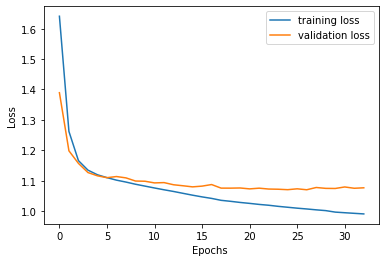

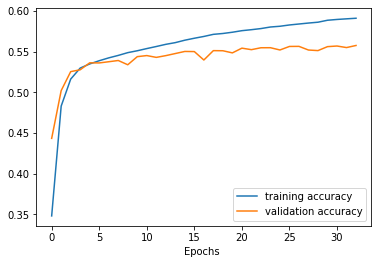

In [ ]:
cnn_history = train_and_plot(
    cnn_model,
    RAW_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS
)
del x_train
cnn_model.load_weights(RAW_CHK)
cnn_model.evaluate(x_val,y_val_encoded)

In [ ]:
cnn_model.load_weights(RAW_CHK)
cnn_model.evaluate(x_val,y_val_encoded)

1313/1313 [==============================] - 4s 3ms/step - loss: 1.0701 - accuracy: 0.5564


[1.070104956626892, 0.5563809275627136]

## Test Results

11250/11250 [==============================] - 22s 2ms/step
              precision    recall  f1-score   support

        8PSK       0.57      0.54      0.55     36000
      AM-DSB       0.51      0.69      0.59     36000
        BPSK       0.55      0.65      0.59     36000
       CPFSK       0.60      0.64      0.62     36000
        GFSK       0.51      0.69      0.59     36000
        PAM4       0.77      0.70      0.73     36000
       QAM16       0.46      0.32      0.38     36000
       QAM64       0.54      0.45      0.49     36000
        QPSK       0.52      0.55      0.53     36000
        WBFM       0.50      0.31      0.38     36000

    accuracy                           0.55    360000
   macro avg       0.55      0.55      0.55    360000
weighted avg       0.55      0.55      0.55    360000



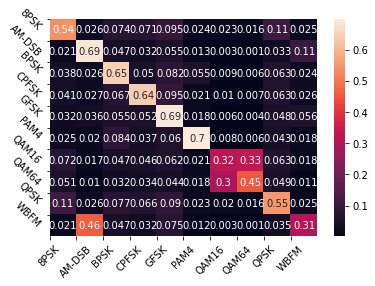

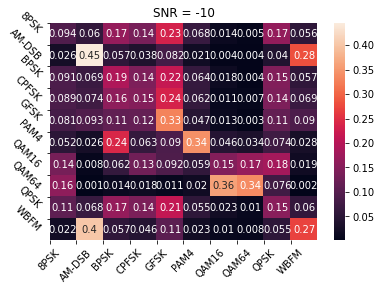

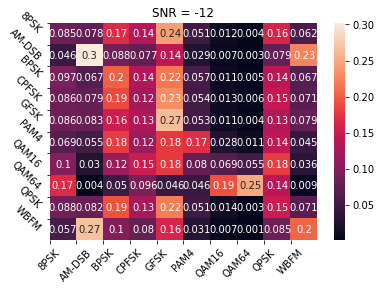

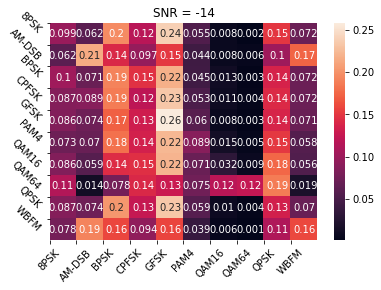

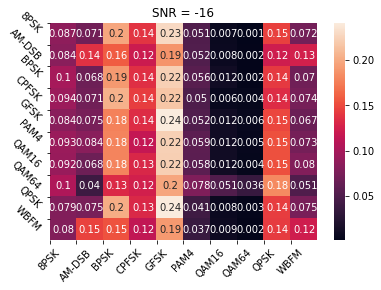

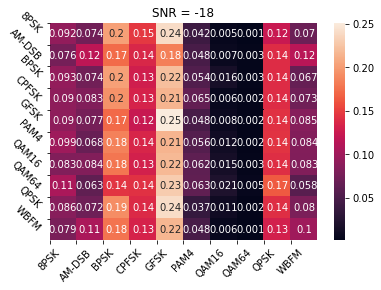

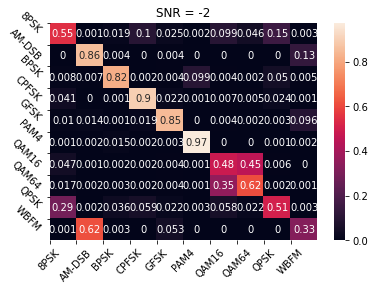

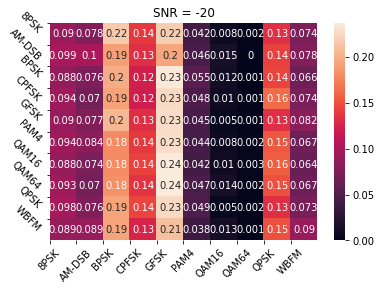

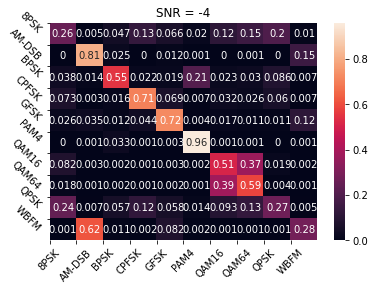

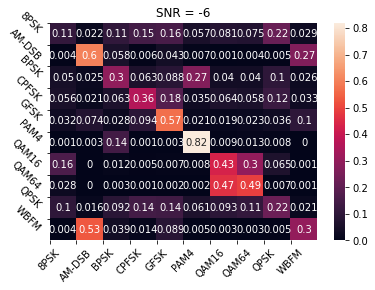

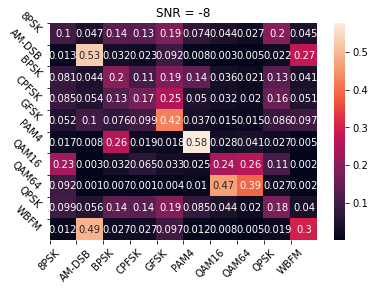

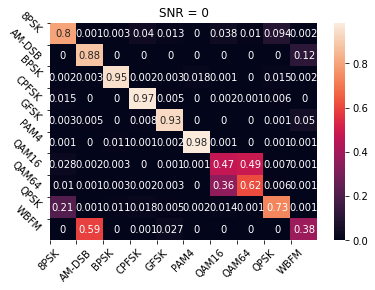

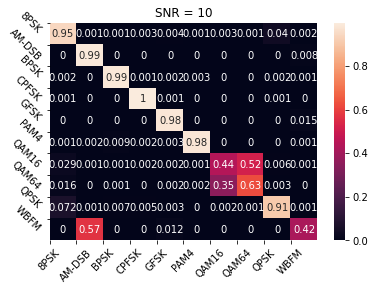

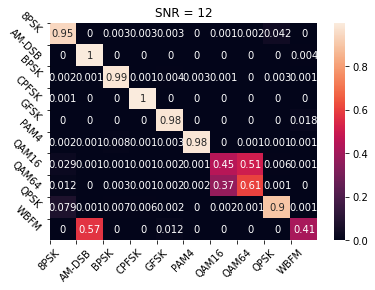

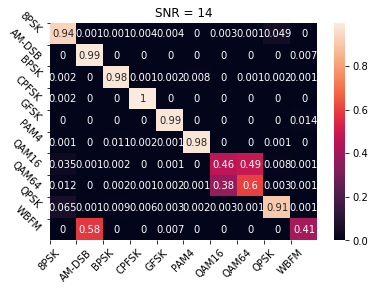

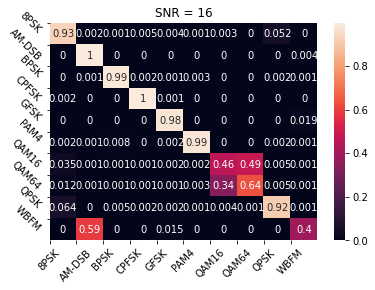

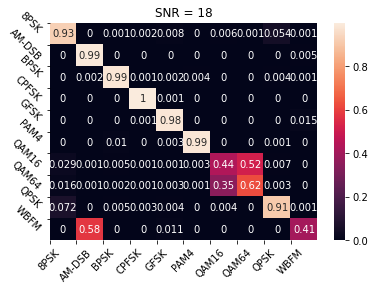

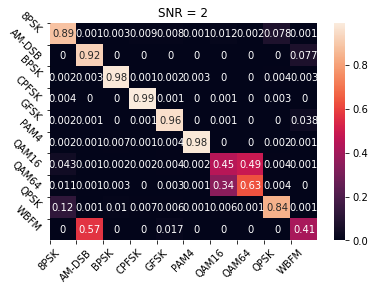

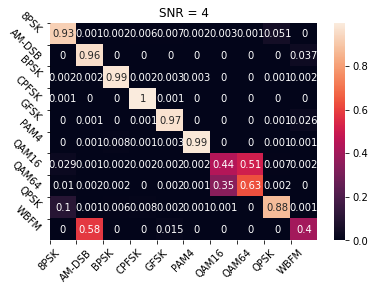

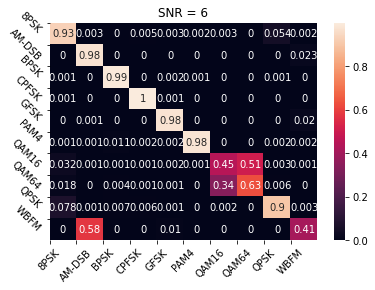

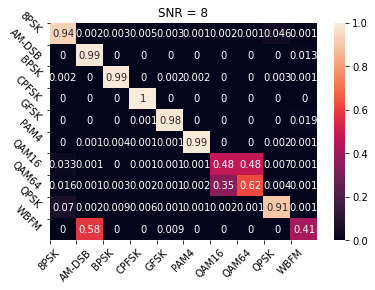

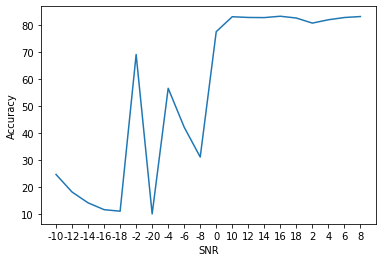

In [ ]:
eval_model(cnn_model,x_test,y_test,y_test_encoded)

### CNN on X diff

In [ ]:
x = np.gradient(X,axis=-1)
cnn_diff_model = create_cnn("cnn_diff",x.shape[1:])

Model: "cnn_diff"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 1, 64)        1216      
                                                                 
 batch_normalization (BatchN  (None, 128, 1, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 1, 16)         9232      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 1, 16)        64        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [ ]:
# ! mkdir /content/drive/MyDrive/out/rml/checkpoints/cnn_diff
OUT = '/content/drive/MyDrive/out/rml/checkpoints'
DIFF_CHK = OUT + '/cnn_diff/checkpoint.h5'


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 21s 8ms/step - loss: 1.4616 - accuracy: 0.4144 - val_loss: 1.4549 - val_accuracy: 0.4243 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 13s 8ms/step - loss: 1.3202 - accuracy: 0.4644 - val_loss: 1.3483 - val_accuracy: 0.4518 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 15s 10ms/step - loss: 1.2818 - accuracy: 0.4780 - val_loss: 1.3261 - val_accuracy: 0.4667 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 12s 8ms/step - loss: 1.2605 - accuracy: 0.4860 - val_loss: 1.2785 - val_accuracy: 0.4776 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/1559 

[1.2671178579330444, 0.4891904890537262]

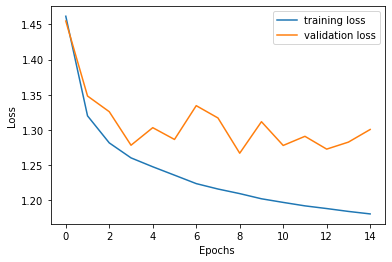

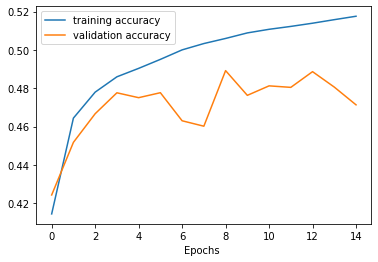

In [ ]:
cnn_diff_history = train_and_plot(
    cnn_diff_model,
    DIFF_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

cnn_diff_model.load_weights(DIFF_CHK)
cnn_diff_model.evaluate(x_val,y_val_encoded)

11250/11250 [==============================] - 22s 2ms/step
              precision    recall  f1-score   support

        8PSK       0.29      0.57      0.38     36000
      AM-DSB       0.44      0.75      0.55     36000
        BPSK       0.60      0.56      0.58     36000
       CPFSK       0.52      0.63      0.57     36000
        GFSK       0.62      0.65      0.63     36000
        PAM4       0.80      0.47      0.59     36000
       QAM16       0.31      0.07      0.12     36000
       QAM64       0.48      0.58      0.53     36000
        QPSK       0.52      0.38      0.44     36000
        WBFM       0.64      0.22      0.33     36000

    accuracy                           0.49    360000
   macro avg       0.52      0.49      0.47    360000
weighted avg       0.52      0.49      0.47    360000



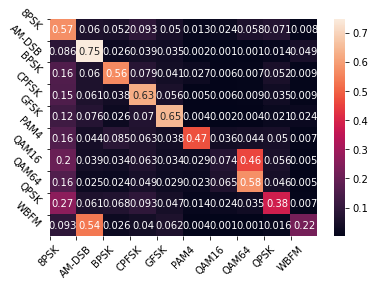

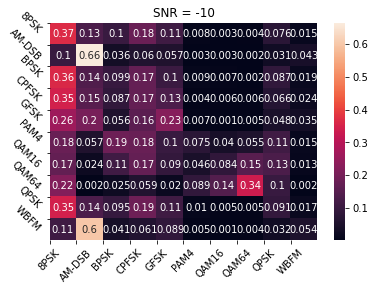

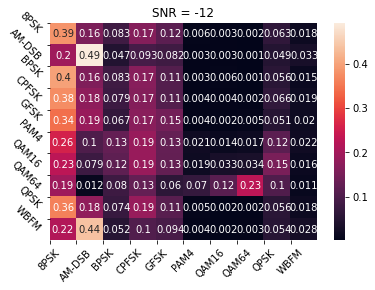

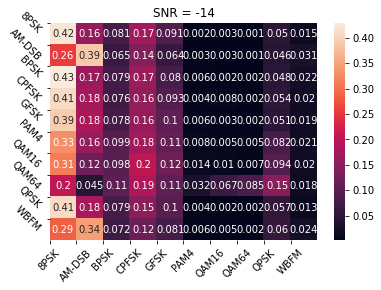

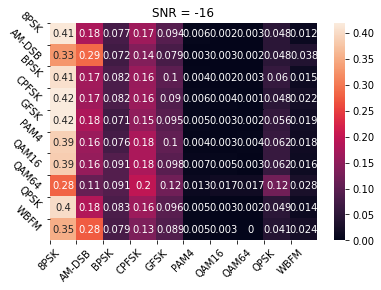

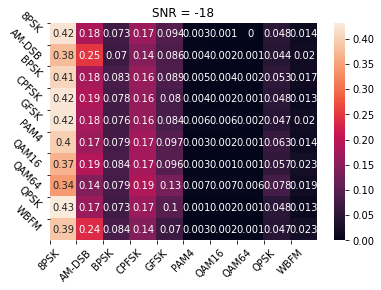

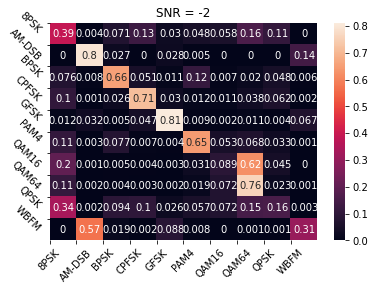

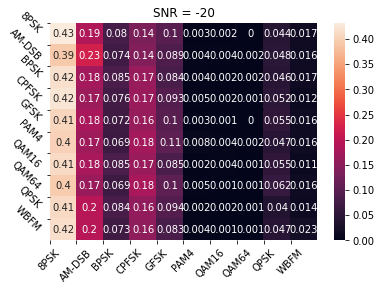

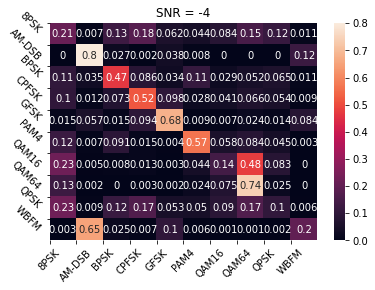

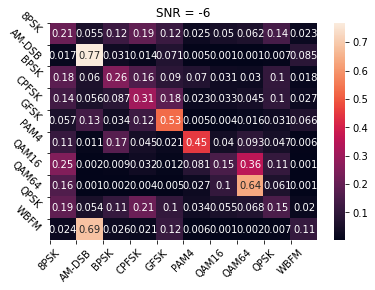

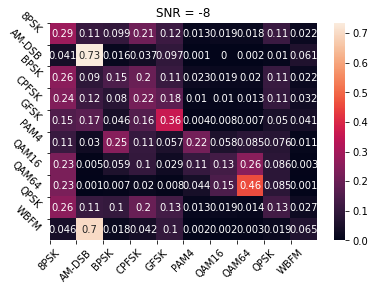

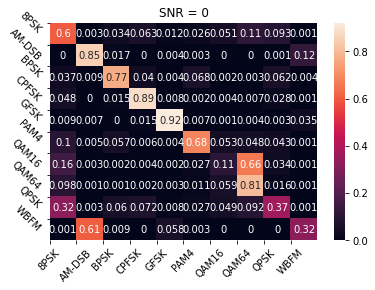

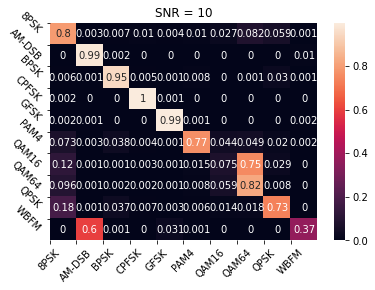

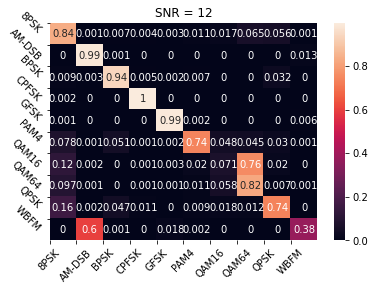

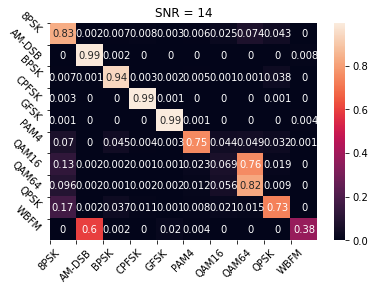

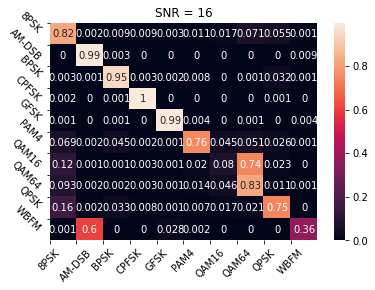

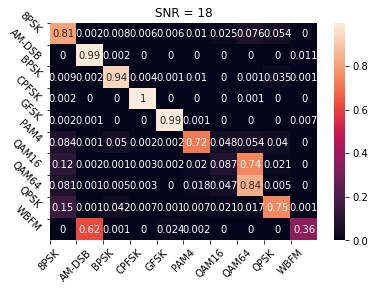

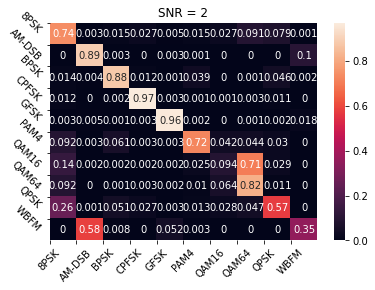

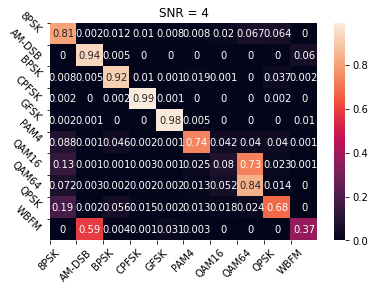

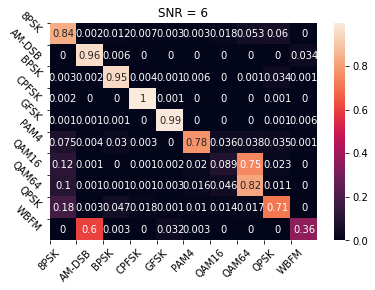

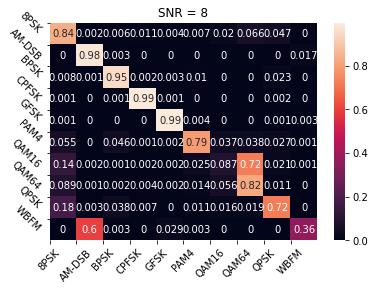

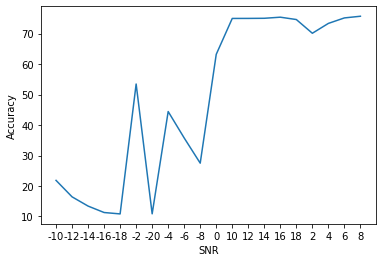

In [ ]:
eval_model(cnn_diff_model,x_test,y_test,y_test_encoded)

In [ ]:
! mkdir /content/drive/MyDrive/out/rml/checkpoints/cnn_int

In [ ]:
OUT = '/content/drive/MyDrive/out/rml/checkpoints'
INT_CHK = OUT + '/cnn_int/checkpoint.h5'

## Combination : all

In [47]:
# del x_all, y
# del trans_all_model , trans_all_history

for _ in range(100):
    gc.collect()

In [22]:
del  x_val, y_train, y_val

In [46]:
X =np.moveaxis(X,-1,1)
x_diff = np.gradient(X,axis=-1)

x_all = np.concatenate((X,x_diff),axis=1)

del x_diff, X
gc.collect()

0

In [48]:
_, _, x_test, _, _, y_test = split(x_all,y)


In [49]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
# y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
# y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape


(360000, 10)

In [ ]:
# ! mkdir '/content/drive/MyDrive/out/rml/checkpoints/trans_all/'
OUT = '/content/drive/MyDrive/out/rml/checkpoints'

ALL_CHK = OUT + '/trans_all/checkpoint.h5'

In [51]:
trans_all_model = create_transformer("trans_all",x_test.shape[1:])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 128)]     0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, 4, 128)      83136       ['input_2[0][0]',                
 rmerEncoder)                                                     'layer_normalization_4[0][0]',  
                                                                  'layer_normalization_5[0][0]',  
                                                                  'layer_normalization_6[0][0]']  
                                                                                                  
 layer_normalization_4 (LayerNo  (None, 4, 128)      256         ['transformer_encoder_1[0][


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 36s 18ms/step - loss: 1.6043 - accuracy: 0.3487 - val_loss: 1.4795 - val_accuracy: 0.3870 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 28s 18ms/step - loss: 1.4271 - accuracy: 0.4047 - val_loss: 1.4046 - val_accuracy: 0.4161 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 31s 20ms/step - loss: 1.3632 - accuracy: 0.4278 - val_loss: 1.3335 - val_accuracy: 0.4395 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 29s 19ms/step - loss: 1.3280 - accuracy: 0.4415 - val_loss: 1.3181 - val_accuracy: 0.4420 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/15

[1.1793267726898193, 0.49604761600494385]

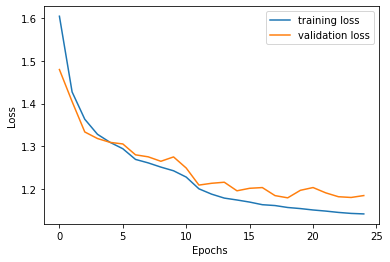

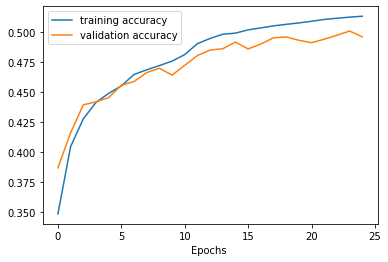

In [20]:
trans_all_history = train_and_plot(
    trans_all_model,
    ALL_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS,
    batch_size=512
)
del x_train

trans_all_model.load_weights(ALL_CHK)
trans_all_model.evaluate(x_val,y_val_encoded)

11250/11250 [==============================] - 44s 4ms/step
              precision    recall  f1-score   support

        8PSK       0.31      0.32      0.32     36000
      AM-DSB       0.42      0.77      0.54     36000
        BPSK       0.41      0.70      0.52     36000
       CPFSK       0.75      0.60      0.67     36000
        GFSK       0.70      0.68      0.69     36000
        PAM4       0.86      0.61      0.71     36000
       QAM16       0.36      0.18      0.24     36000
       QAM64       0.52      0.45      0.49     36000
        QPSK       0.33      0.36      0.34     36000
        WBFM       0.58      0.28      0.37     36000

    accuracy                           0.49    360000
   macro avg       0.52      0.49      0.49    360000
weighted avg       0.52      0.49      0.49    360000



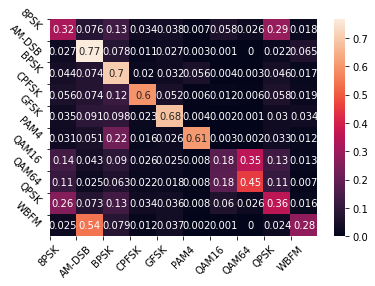

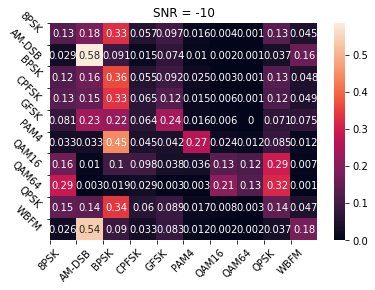

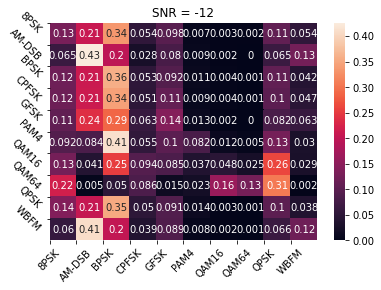

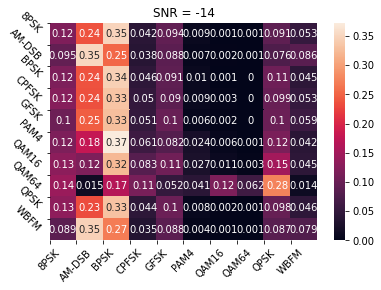

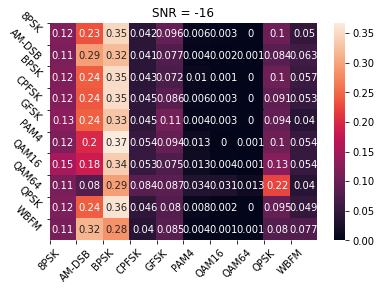

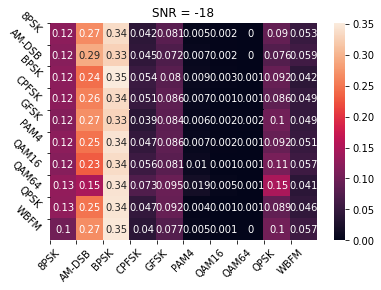

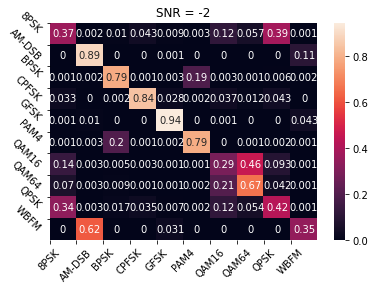

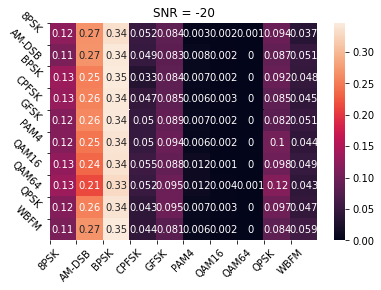

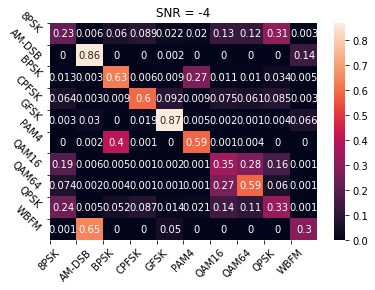

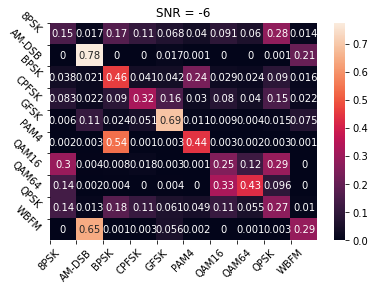

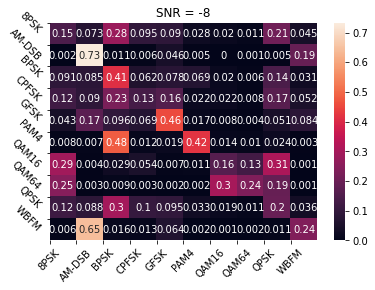

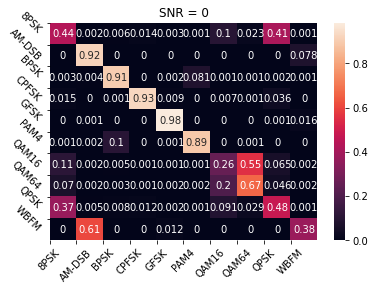

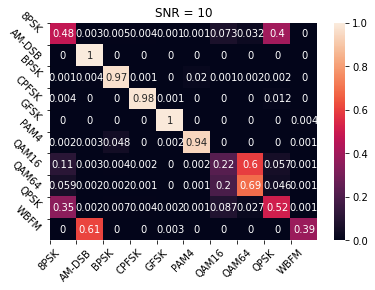

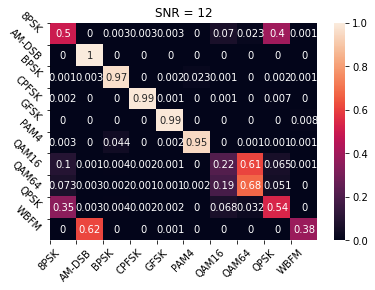

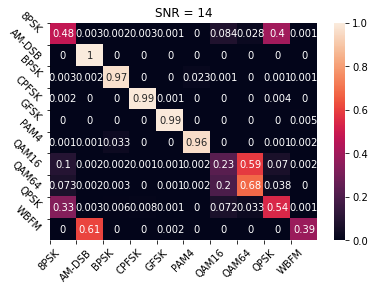

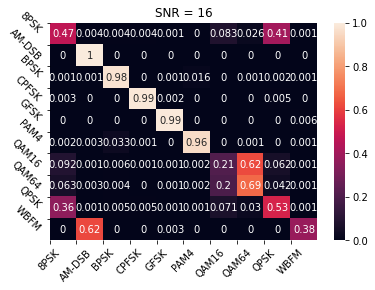

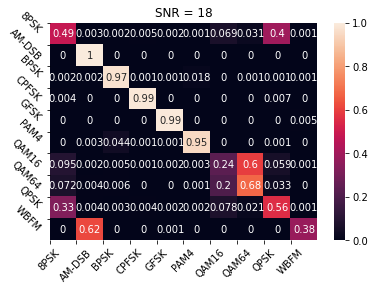

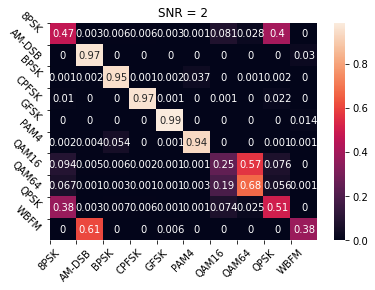

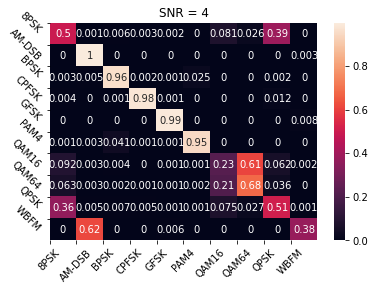

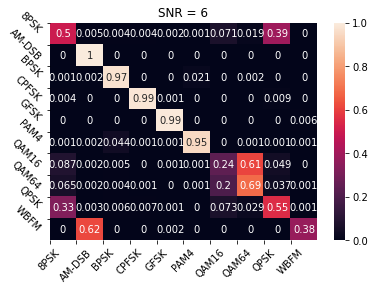

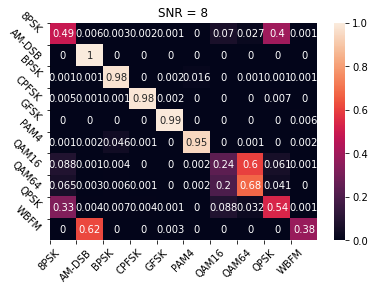

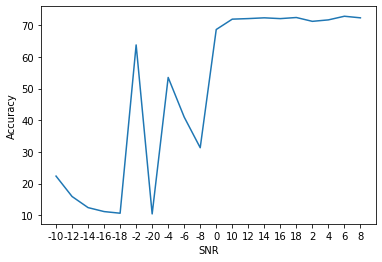

In [52]:
trans_all_model.load_weights(ALL_CHK)
eval_model(trans_all_model,x_test,y_test,y_test_encoded)

## Embedding SNR with the input

In [16]:
del X
gc.collect()

0

In [11]:
SNR = np.array(y[:,1])[:,np.newaxis,np.newaxis].astype(int).repeat(2,axis=-1)
SNR[0]
X_embed =np.moveaxis( np.concatenate((X,SNR),axis=1),-1,1)

In [12]:
SNR.shape, X_embed.shape

((1200000, 1, 2), (1200000, 2, 129))

In [13]:
# ! mkdir /content/drive/MyDrive/out/rml/checkpoints/trans_embed
EMBED_CHK = OUT + '/trans_embed/checkpoint.h5'

In [14]:
trans_embed_model = create_transformer("trans_embed",X_embed.shape[1:])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 129)]     0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, 2, 129)      83782       ['input_1[0][0]',                
 erEncoder)                                                       'layer_normalization[0][0]',    
                                                                  'layer_normalization_1[0][0]',  
                                                                  'layer_normalization_2[0][0]']  
                                                                                                  
 layer_normalization (LayerNorm  (None, 2, 129)      258         ['transformer_encoder[0][0]']

In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = split(X_embed,y)
del X_embed, y 
gc.collect()

encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)


Epoch 1: LearningRateScheduler setting learning rate to 0.0009.
Epoch 1/100
1559/1559 [==============================] - 31s 16ms/step - loss: 2.0262 - accuracy: 0.1931 - val_loss: 1.6963 - val_accuracy: 0.3060 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009.
Epoch 2/100
1559/1559 [==============================] - 22s 14ms/step - loss: 1.4661 - accuracy: 0.3822 - val_loss: 1.3589 - val_accuracy: 0.4222 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009.
Epoch 3/100
1559/1559 [==============================] - 22s 14ms/step - loss: 1.3105 - accuracy: 0.4421 - val_loss: 1.2750 - val_accuracy: 0.4564 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009.
Epoch 4/100
1559/1559 [==============================] - 22s 14ms/step - loss: 1.2578 - accuracy: 0.4652 - val_loss: 1.2851 - val_accuracy: 0.4591 - lr: 9.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009.
Epoch 5/100
1559/15

[1.0282708406448364, 0.5542380809783936]

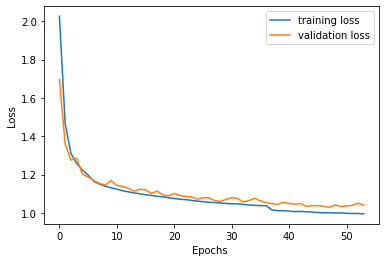

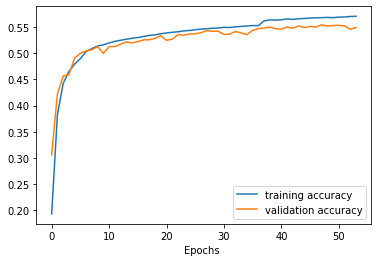

In [17]:
trans_embed_history = train_and_plot(
    trans_embed_model,
    EMBED_CHK,
    x_train,
    y_train_encoded,
    x_val,
    y_val_encoded,
    epochs=EPOCHS
)
del x_train
trans_embed_model.load_weights(EMBED_CHK)
trans_embed_model.evaluate(x_val,y_val_encoded)

11250/11250 [==============================] - 35s 3ms/step
              precision    recall  f1-score   support

        8PSK       0.36      0.36      0.36     36000
      AM-DSB       0.56      0.64      0.59     36000
        BPSK       0.88      0.62      0.73     36000
       CPFSK       0.57      0.68      0.62     36000
        GFSK       0.75      0.69      0.72     36000
        PAM4       0.58      0.78      0.66     36000
       QAM16       0.42      0.45      0.43     36000
       QAM64       0.50      0.68      0.57     36000
        QPSK       0.47      0.29      0.36     36000
        WBFM       0.57      0.37      0.45     36000

    accuracy                           0.56    360000
   macro avg       0.56      0.56      0.55    360000
weighted avg       0.56      0.56      0.55    360000



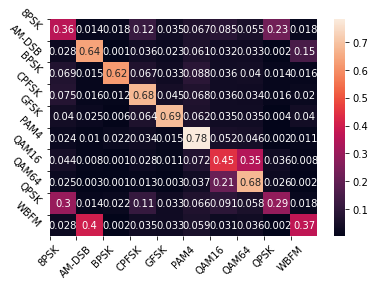

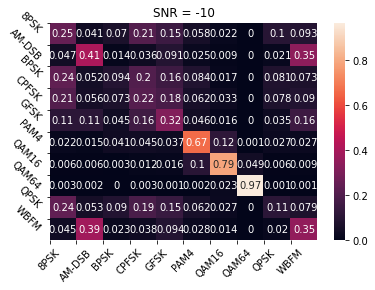

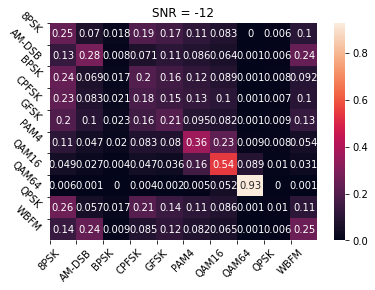

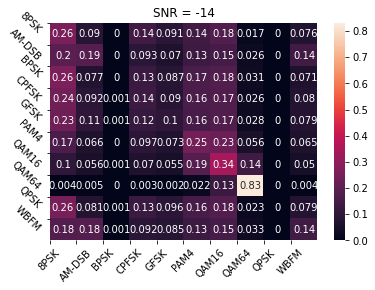

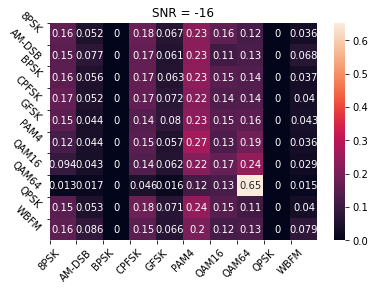

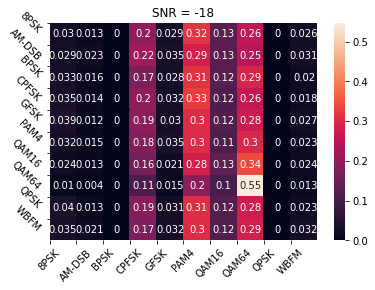

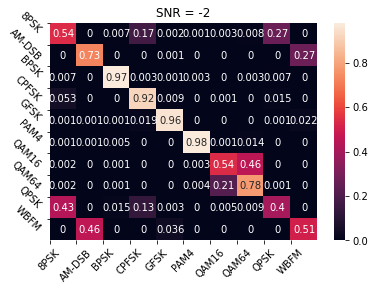

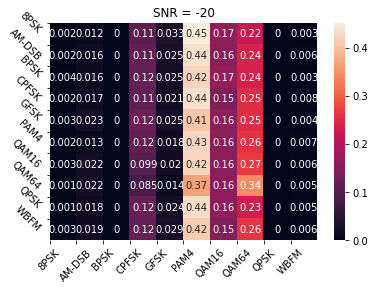

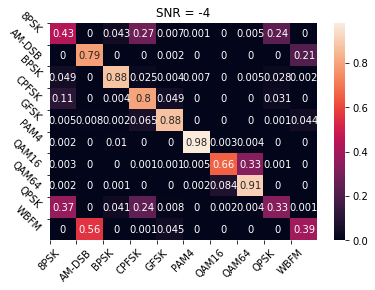

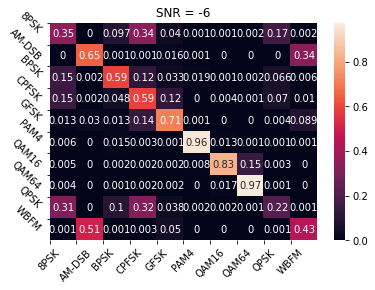

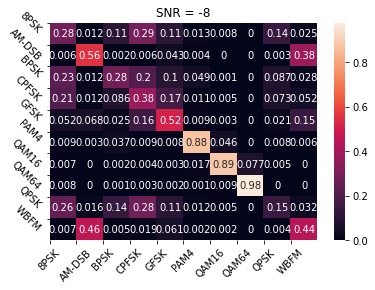

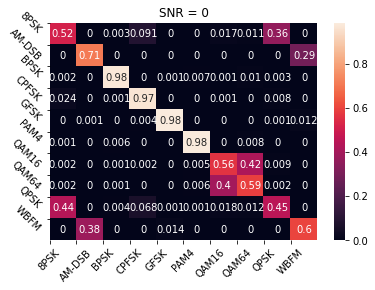

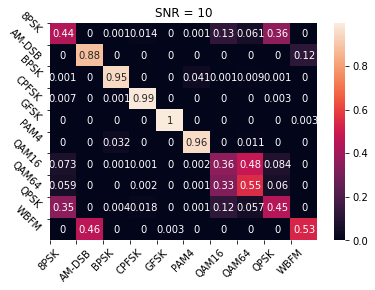

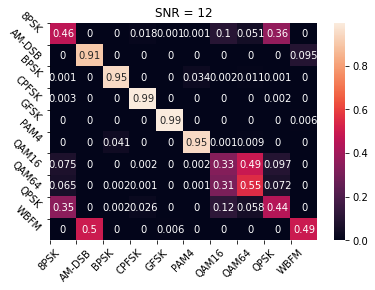

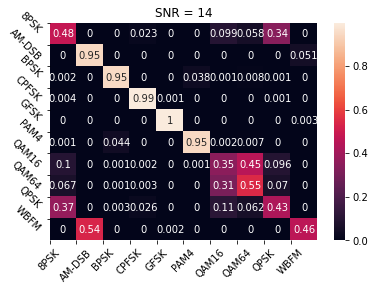

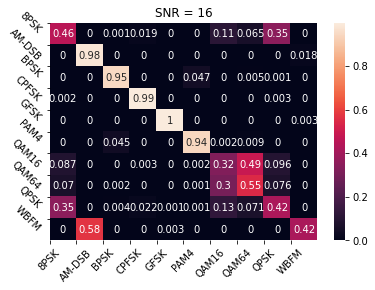

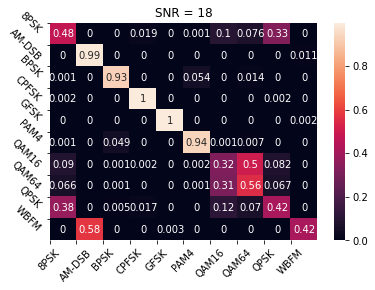

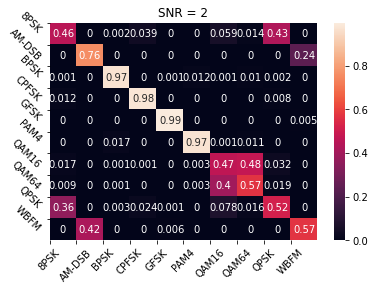

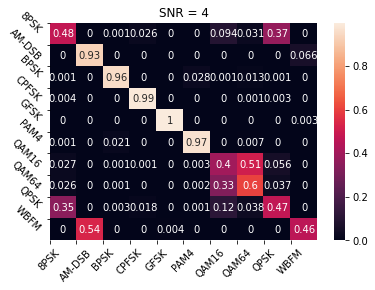

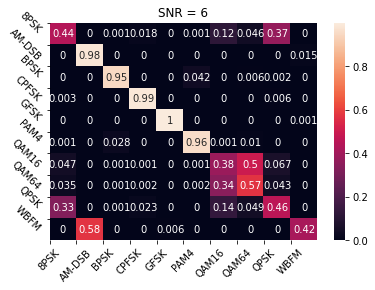

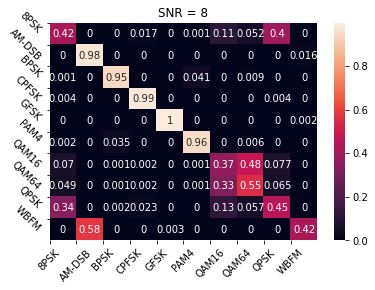

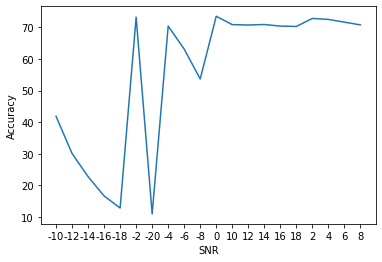

In [22]:
eval_model(trans_embed_model,x_test,y_test,y_test_encoded)